In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

data_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data_folder"))
sys.path.append(data_folder_path) 

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000001D6B3FCC860> at 0x000001D6CC640B00>

In [2]:
def plot_data(N, M, V, gap_or_sigma="energy_gap", include_path=False,
              path_data=None, resolution=250, min_J_V_ratio=-10, max_J_V_ratio=10, max_mu_V_ratio=10):
    """
    Compute and plot energy gap or synthetic distance (sigma) over a grid of (mu/|V|, J/|V|),
    and optionally overlay a control path.

    Parameters:
    -----------
    N, M : int
        Number of sites and synthetic levels.
    V : float
        Interaction strength.
    gap_or_sigma : str
        Either "energy_gap" or "sigma" to select what to plot.
    include_path : bool
        If True, overlay a control path.
    path_data : dict
        Dictionary with keys "times", "J_V_ratios", "mu_V_ratios". Only used if include_path=True.
    resolution : int
        Grid resolution.
    min_J_V_ratio, max_J_V_ratio, max_mu_V_ratio : float
        Limits for J/|V| and μ/|V| axes.
    """

    sign_V = "positive" if V > 0 else "negative"
    mu_V_ratios = np.linspace(0, max_mu_V_ratio, resolution)
    J_V_ratios = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)
    mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(mu_V_ratios, J_V_ratios)

    # Allocate memory
    sigma_grid = np.zeros_like(mu_V_ratio_grid)
    energy_gap_grid = np.zeros_like(mu_V_ratio_grid)
    states, _ = enumerate_states(N, M)

    # Parallel computation
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_index = {}
        for i, mu in enumerate(mu_V_ratios):
            for j, J in enumerate(J_V_ratios):
                future = executor.submit(compute_values, mu, J, V, N, M, states)
                future_to_index[future] = (j, i)

        for future in concurrent.futures.as_completed(future_to_index):
            j, i = future_to_index[future]
            try:
                energy_gap, sigma = future.result()
                energy_gap_grid[j, i] = energy_gap
                sigma_grid[j, i] = sigma
            except Exception as e:
                print(f"Error at ({j},{i}): {e}")

    # Choose Z data
    if gap_or_sigma == "energy_gap":
        with np.errstate(divide='ignore'):
            Z = np.log(1 / energy_gap_grid)
        plot_title = "Energy Gap"
        color_label = r"$\log(1/\Delta E)$"
    else:
        Z = sigma_grid
        plot_title = "Synthetic Distance"
        color_label = r"$\sigma/M$"

    # Create plot grid
    J_grid, mu_grid = np.meshgrid(J_V_ratios, mu_V_ratios, indexing='ij')

    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(J_grid, mu_grid, Z, shading='auto', cmap='plasma')

    if include_path and path_data is not None:
        from matplotlib.collections import LineCollection
        times = np.array(path_data['times'])
        J_path = np.array(path_data['J_V_ratios'])
        mu_path = np.array(path_data['mu_V_ratios'])

        points = np.array([J_path, mu_path]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='gist_rainbow', norm=plt.Normalize(times.min(), times.max()))
        lc.set_array(times)
        lc.set_linewidth(2)
        ax.add_collection(lc)
        fig.colorbar(lc, ax=ax, label='t/|V|')

    ax.set_ylim(0, max_mu_V_ratio)
    ax.set_xlim(min_J_V_ratio, max_J_V_ratio)

    sign_str = r"$V > 0$" if V > 0 else r"$V < 0$"
    ax.set_title(f"{plot_title}: $N={N}$, $M={M}$, {sign_str}")
    ax.set_xlabel(r"$J/|V|$")
    ax.set_ylabel(r"$\mu/|V|$")
    fig.colorbar(pcm, ax=ax, label=color_label)
    plt.tight_layout()
    plt.show()
    
def compute_values(mu_V_ratio, J_V_ratio, V, N, M, states):
    """Compute energy gap and sigma for given parameters."""
    H = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(H)
    energy_gap = eigenvalues[1] - eigenvalues[0]
    sigma = sigma_ij(0, 1, eigenvectors[0], states, N, M) / M
    return energy_gap, sigma


In [3]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def construct_anisotropic_hamiltonian(N, M, V, mu, J, anisotropy_factor=1.0, chemical_potential_loc=1):
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)
    
    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == chemical_potential_loc:
                H[alpha, alpha] -= mu

    # Tunneling term (level lowering)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            n = state[j]
            if n > 0:
                new_state = state.copy()
                new_state[j] = n - 1
                beta = state_to_index(new_state)
                H[alpha, beta] -= J
                H[beta, alpha] -= J

    # Interaction term (between neighbors)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            a, b = state[i], state[i+1]
            if a == 1 and b == 0:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 0, 1
                beta = state_to_index(new_state)
                H[alpha, beta] += anisotropy_factor * V
                H[beta, alpha] += anisotropy_factor * V
            elif a == 2 and b == 1:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 1, 2
                beta = state_to_index(new_state)
                H[alpha, beta] += V
                H[beta, alpha] += V

    return H

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def create_optimal_piecewise_linear_paths_anisotropic_case(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points, anisotropy_factor = 0.9, initial_guess=None):

    times_dense = np.arange(0, T + dt, dt)
    n_points = num_control_points
    n_int = n_points - 2

    # If initial_guess provided, use it; else use linear interpolation
    if initial_guess is not None:
        x0 = initial_guess
        # Optionally, validate length of initial_guess matches expected
        expected_len = 3 * n_int
        if len(x0) != expected_len:
            raise ValueError(f"initial_guess length {len(x0)} does not match expected {expected_len}")
    else:
        J_initial_guess = np.linspace(J_V_init, J_V_final, n_points)[1:-1]
        mu_initial_guess = np.linspace(mu_V_init, mu_V_final, n_points)[1:-1]
        t_initial_guess = T * np.linspace(0, 1, n_points)[1:-1]
        x0 = np.concatenate((J_initial_guess, mu_initial_guess, t_initial_guess))

    eps = 1e-3
    cons = []
    cons.append({'type': 'ineq', 'fun': lambda x: x[2*n_int] - eps})
    for i in range(1, n_int):
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[2*n_int + i] - x[2*n_int + i - 1] - eps})  
    cons.append({'type': 'ineq', 'fun': lambda x: T - x[2*n_int + n_int - 1] - eps}) 

    # mu must decrease monotonically
    for i in range(1, n_int):
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[n_int + i - 1] - x[n_int + i] - eps})

    loop_weight = 0.1

    def objective(x):
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]

        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))

        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)

        negative_mu_penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        negative_J_penalty = np.sum(np.abs(np.minimum(0, J_path_dense)))

        delta_Js = np.diff(J_control)
        delta_mus = np.diff(mu_control)
        path_length = np.sum(np.sqrt(delta_Js**2 + delta_mus**2))
        straight_line_distance = np.sqrt((J_V_final - J_V_init)**2 + (mu_V_final - mu_V_init)**2)
        loop_penalty = loop_weight * (path_length - straight_line_distance)

        hamiltonians = []
        for i, t in enumerate(times_dense):
            mu = np.abs(V) * mu_path_dense[i]
            J = np.abs(V) * J_path_dense[i]
            ham = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor = anisotropy_factor)
            hamiltonians.append(ham)

        _, _, _, _, _, calculate_ground_state_manifold_overlaps = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        ground_state_fidelity = calculate_ground_state_manifold_overlaps[-1]
        ground_state_infidelity = 1 - ground_state_fidelity

        return ground_state_infidelity + negative_J_penalty + negative_mu_penalty + loop_penalty

    result = minimize(objective, x0, method='SLSQP', constraints=cons, options={'maxiter': 1000, 'ftol': 1e-9, 'disp': True})

    #print(result.message)
    print("Success:", result.success)

    opt_params = result.x
    J_int_opt = opt_params[:n_int]
    mu_int_opt = opt_params[n_int:2*n_int]
    t_int_opt = opt_params[2*n_int:3*n_int]

    J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
    mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
    t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

    J_V_path = np.interp(times_dense, t_control_opt, J_control_opt)
    mu_V_path = np.interp(times_dense, t_control_opt, mu_control_opt)

    obj_value = result.fun
    return (times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
N = 3 # trying a new way to prepare antisymmetric strings maybe
M = 3 
V = 1
dt = 0.1

J_V_init = 0
J_V_final = 0.2
mu_V_init = 10
mu_V_final = 0

num_control_points = 12

Ts = np.linspace(0.1,10,10)

In [5]:
ground_state_overlaps = []
energy_differences = []

opt_params = None

for T in Ts:
    
    print(f"\nOptimizing for T = {T}")
    
    results = create_optimal_piecewise_linear_paths(
        N, M, T, dt, V,
        J_V_init, J_V_final,
        mu_V_init, mu_V_final,
        num_control_points,
        initial_guess=opt_params
    )
    
    times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results
    
    hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]
    final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results
    gso = ground_state_manifold_overlaps[-1]
    ground_state_overlaps.append(gso)
    ed = energies[-1] - true_energies[-1,0]
    energy_differences.append(ed)
    
    print(f"GROUND_STATE_OVERLAP: {gso:.6f}")
    print(f"ENERGY_DIFFERENCE: {ed:.6f}")
    print()
    
print("All finished:")
print(f"Evolution Times: {Ts}")
print(f"Ground State Overlaps = {ground_state_overlaps}")
print(f"Energy Differences = {ground_state_overlaps}")


Optimizing for T = 0.1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9997362501654115
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Success: True
GROUND_STATE_OVERLAP: 0.000264
ENERGY_DIFFERENCE: 2.246980


Optimizing for T = 1.2000000000000002


KeyboardInterrupt: 

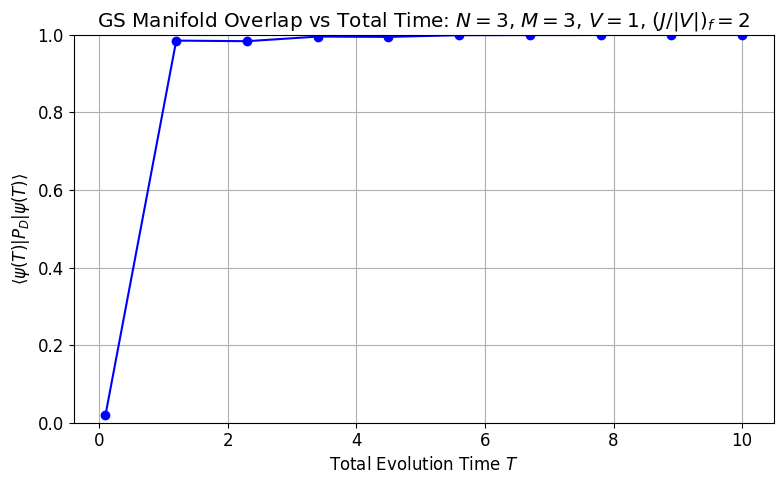

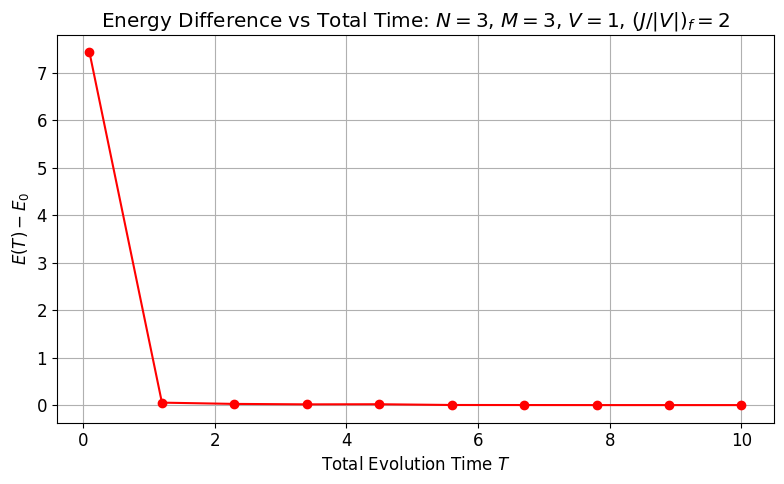

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ts[:len(ground_state_overlaps)], ground_state_overlaps, marker='o', color = "blue")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$\langle \psi(T) | P_D | \psi(T) \\rangle$')
plt.title(f'GS Manifold Overlap vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(Ts[:len(ground_state_overlaps)], energy_differences, marker='o', color = "red")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$E(T) - E_0$')
plt.title(f'Energy Difference vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.grid(True)
plt.tight_layout()
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00015833405112466447
            Iterations: 220
            Function evaluations: 6891
            Gradient evaluations: 220
Success: True


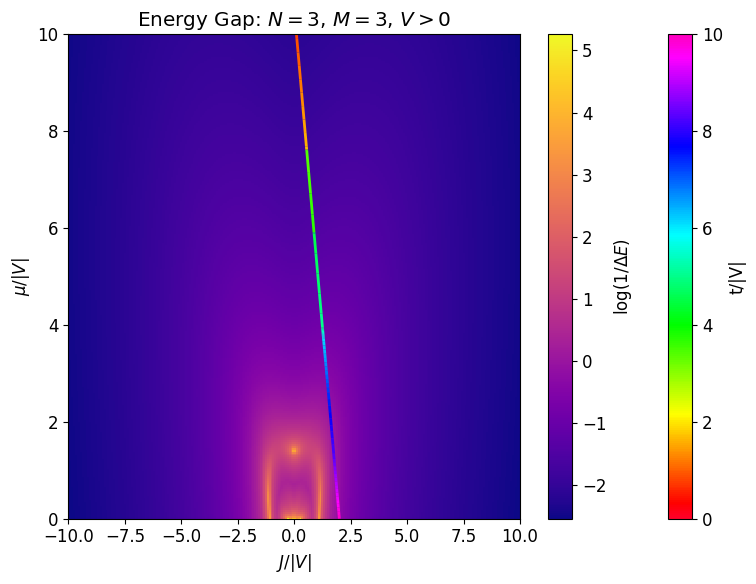

In [ ]:
# Identify best T (highest ground state overlap)
best_index = np.argmax(ground_state_overlaps)
best_T = Ts[best_index]

# Recompute best path
results = create_optimal_piecewise_linear_paths_anisotropic_case(
    N, M, best_T, dt, V,
    J_V_init, J_V_final,
    mu_V_init, mu_V_final,
    num_control_points,
    initial_guess=None
)
times_dense, J_V_path, mu_V_path, *_ = results

# Now plot
plot_data(
    N=N,
    M=M,
    V=V,
    gap_or_sigma="energy_gap",  # or "sigma"
    include_path=True,
    path_data={
        "times": times_dense,
        "J_V_ratios": J_V_path,
        "mu_V_ratios": mu_V_path
    }
)


In [ ]:
# now, how are things changed by an anisotropic dipole dipole interaction (10% diff between 0->1 exchange and 1->2 exchange)

anisotropy_factor = 0.9

anisotropic_ground_state_overlaps = []
anisotropic_energy_differences = []

opt_params = None

for T in Ts:    
    print(f"\nOptimizing for T = {T}")
    
    results = create_optimal_piecewise_linear_paths_anisotropic_case(
        N, M, T, dt, V,
        J_V_init, J_V_final,
        mu_V_init, mu_V_final,
        num_control_points,
        initial_guess=opt_params
    )
    
    times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results    
    hamiltonians = [construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu_V_path[i], J = J_V_path[i], anisotropy_factor = anisotropy_factor)/np.abs(V) for i in range(len(times_dense))]
    
    final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results
    gso = ground_state_manifold_overlaps[-1]
    anisotropic_ground_state_overlaps.append(gso)
    ed = energies[-1] - true_energies[-1,0]
    anisotropic_energy_differences.append(ed)
    
    print(f"GROUND_STATE_OVERLAP: {gso:.6f}")
    print(f"ENERGY_DIFFERENCE: {ed:.6f}")
    print()
    
print("All finished:")
print(f"Evolution Times: {Ts}")
print(f"Ground State Overlaps = {anisotropic_ground_state_overlaps}")
print(f"Energy Differences = {anisotropic_energy_differences}")


Optimizing for T = 0.1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9794657033970944
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1
Success: True
GROUND_STATE_OVERLAP: 0.020534
ENERGY_DIFFERENCE: 7.472521


Optimizing for T = 1.2000000000000002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.041752849393227126
            Iterations: 118
            Function evaluations: 3717
            Gradient evaluations: 118
Success: True
GROUND_STATE_OVERLAP: 0.988275
ENERGY_DIFFERENCE: 0.045289


Optimizing for T = 2.3000000000000003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.014564749791088839
            Iterations: 231
            Function evaluations: 7256
            Gradient evaluations: 231
Success: True
GROUND_STATE_OVERLAP: 0.988081
ENERGY_DIFFERENCE: 0.020627


Optimizing for T = 3.40000000000000

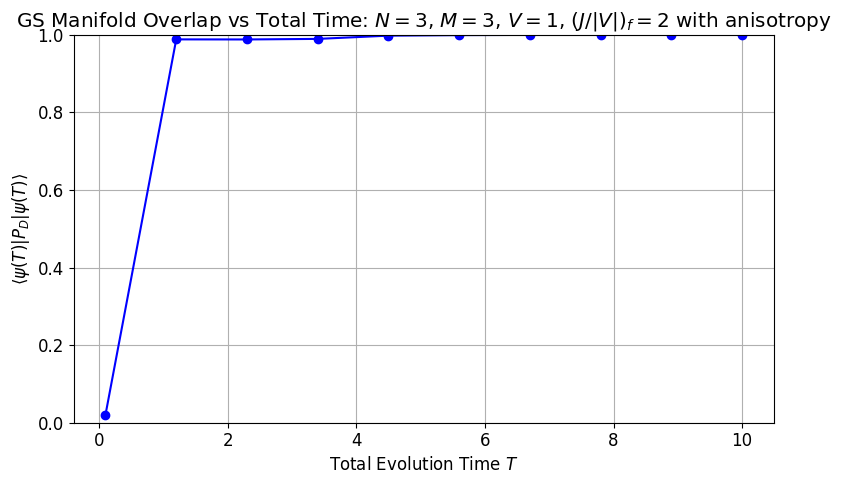

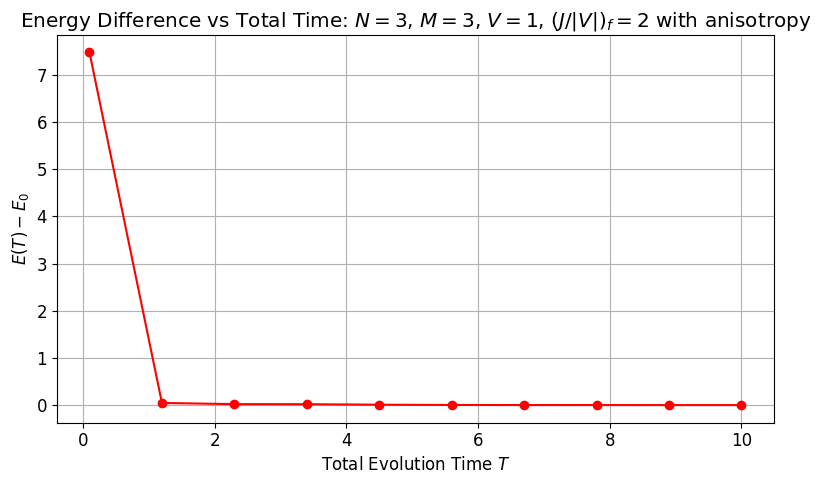

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ts[:len(anisotropic_ground_state_overlaps)], anisotropic_ground_state_overlaps, marker='o', color = "blue")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$\langle \psi(T) | P_D | \psi(T) \\rangle$')
plt.title(f'GS Manifold Overlap vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$ with anisotropy')
plt.grid(True)
plt.ylim(0,1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(Ts[:len(anisotropic_energy_differences)], anisotropic_energy_differences, marker='o', color = "red")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$E(T) - E_0$')
plt.title(f'Energy Difference vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$ with anisotropy')
plt.grid(True)
plt.tight_layout()
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00015833405112466447
            Iterations: 220
            Function evaluations: 6891
            Gradient evaluations: 220
Success: True


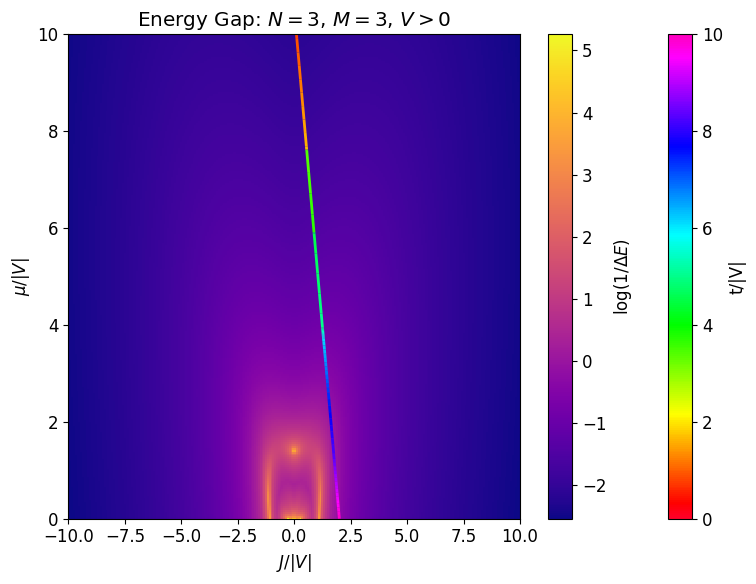

In [ ]:
# Identify best T (highest ground state overlap)
best_index = np.argmax(anisotropic_ground_state_overlaps)
best_T = Ts[best_index]

# Recompute best path
results = create_optimal_piecewise_linear_paths_anisotropic_case(
    N, M, best_T, dt, V,
    J_V_init, J_V_final,
    mu_V_init, mu_V_final,
    num_control_points,
    initial_guess=None
)
times_dense, J_V_path, mu_V_path, *_ = results

# Now plot
plot_data(
    N=N,
    M=M,
    V=V,
    gap_or_sigma="energy_gap",  # or "sigma"
    include_path=True,
    path_data={
        "times": times_dense,
        "J_V_ratios": J_V_path,
        "mu_V_ratios": mu_V_path
    }
)


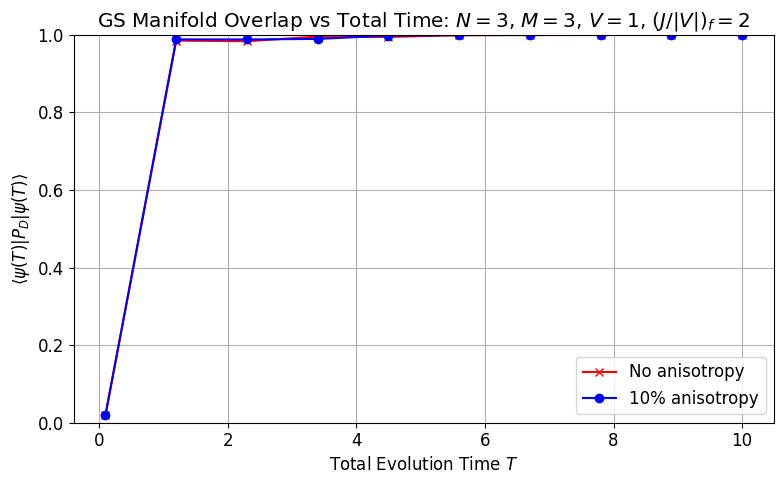

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ts[:len(ground_state_overlaps)], ground_state_overlaps, marker='x', color = "r", label = "No anisotropy")
plt.plot(Ts[:len(anisotropic_ground_state_overlaps)], anisotropic_ground_state_overlaps, marker='o', color = "blue", label = r"10% anisotropy")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$\langle \psi(T) | P_D | \psi(T) \\rangle$')
plt.title(f'GS Manifold Overlap vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.grid(True)
plt.ylim(0,1.0)
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

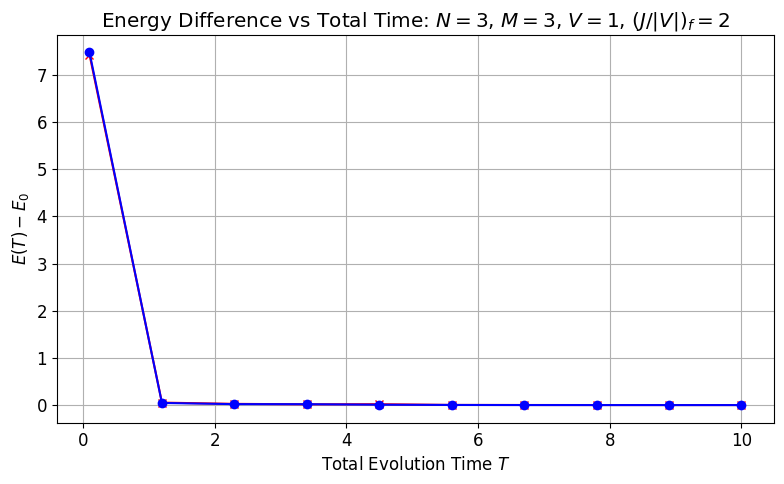

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ts[:len(energy_differences)], energy_differences, marker='x', color = "red", label = "No anisotropy")
plt.plot(Ts[:len(anisotropic_energy_differences)], anisotropic_energy_differences, marker='o', color = "blue", label = r"10% anisotropy")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$E(T) - E_0$')
plt.title(f'Energy Difference vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.grid(True)
plt.tight_layout()
plt.show()